# Analisi Dati: Efficientamento Energetico
<img src="https://www.pozzicase.it/sites/default/files/styles/immagine_wide_blocco_a/public/casa/main.jpg?itok=jVvRVwpp" width="700">

Abbiamo trovato [qui](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/whiteside.html) dei dati riguardo al consumo di gas una casa, la cui descrizione è la seguente:

_"Mr Derek Whiteside of the UK Building Research Station recorded the weekly gas consumption and average external temperature at his own house in south-east England for two heating seasons, one of 26 weeks before, and one of 30 weeks after cavity-wall insulation was installed. The object of the exercise was to assess the effect of the insulation on gas consumption."_

Sembra interessante! Forse questi dati ci aiuteranno a capire se vale la pena investire nell'efficientamento energetico di una casa.

In [225]:
# Importiamo le librerie necessarie
import numpy as np
import pandas as pd
import urllib.request
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [226]:
# Qualche funzione utile
CARTELLA_DATI = 'dati'
plt.rcParams['figure.figsize'] = [10, 8]

def download(url, filename):
    os.makedirs('dati', exist_ok=True)
    if not os.path.exists(filename):
        print('Sto scaricando ' + filename + ' ...')
        urllib.request.urlretrieve(url, 'dati/dataset.csv')
        print('fatto!')
    else:
        print('File ' + filename + ' già scaricato.')
        
def plot_regression(model, X, y):
    plt.scatter(X, y, color='blue')
    plt.plot(X, model.predict(X), color='red')
    plt.show()
    

Prima di tutto, dobbiamo scaricare i dati e vedere di cosa si tratta

In [227]:
# Ora scarichiamo i dati
LINK_GASDATA = 'https://www.dropbox.com/scl/fi/plnv6zacnm5i463hswdsk/gasdata.csv?rlkey=21zubn1z3g004y4rtupljx3g9&dl=1'
LINK_WHITESIDE = 'https://www.dropbox.com/scl/fi/dz7zvitffxe5qk0ylb20j/whiteside.csv?rlkey=kpjp3pnte5raproyluivqmrz4&dl=1'
DATASET_NAME = 'dataset.csv'
dataset = f"{CARTELLA_DATI}/{DATASET_NAME}"

download(LINK_WHITESIDE, dataset)

File dati/dataset.csv già scaricato.


In [228]:
# I dati sono stati scaricati in una cartella chiamata 'dati' e il file si chiama 'dataset.csv', ora li possiamo caricare con pandas
df = pd.read_csv('dati/dataset.csv')

Bene, ora che abbiamo caricato il dataset, possiamo vedere quali colonne ha la nostra tabella.

In [229]:
df

,Insul,Temp,Gas
0,Before,-0.8,7.2
1,Before,-0.7,6.9
2,Before,0.4,6.4
3,Before,2.5,6.0
4,Before,2.9,5.8
5,Before,3.2,5.8
6,Before,3.6,5.6
7,Before,3.9,4.7
8,Before,4.2,5.8
9,Before,4.3,5.2


La tabella ha 3 colonne e 56 righe:
- "Insul" indica se alla casa è stato fatto l'intervento di efficientamento energetico (probabilmente il cappotto termico). I valori possibili sono solo "Before" e "After".
- "Temp" è la temperatura esterna media di una data settimana
- "Gas" indica il consumo totale per una data settimana

Vogliamo vedere se dopo aver messo il cappotto termico il consumo di gas si è abbassato.
Possiamo iniziare calcolando la media del consumo di gas settimanale prima e dopo l'intervento:

In [230]:
# Per facilitarci la vita, creiamo due dataframe separati per i dati prima e dopo l'isolamento
df_before = df[df['Insul']=='Before'].reset_index(drop=True)
df_after = df[df['Insul']=='After'].reset_index(drop=True)

In [231]:
df_before

,Insul,Temp,Gas
0,Before,-0.8,7.2
1,Before,-0.7,6.9
2,Before,0.4,6.4
3,Before,2.5,6.0
4,Before,2.9,5.8
5,Before,3.2,5.8
6,Before,3.6,5.6
7,Before,3.9,4.7
8,Before,4.2,5.8
9,Before,4.3,5.2


In [232]:
df_after

,Insul,Temp,Gas
0,After,-0.7,4.8
1,After,0.8,4.6
2,After,1.0,4.7
3,After,1.4,4.0
4,After,1.5,4.2
5,After,1.6,4.2
6,After,2.3,4.1
7,After,2.5,4.0
8,After,2.5,3.5
9,After,3.1,3.2


In [233]:
# Ora calcoliamo la media del consumo di gas prima e dopo l'isolamento
consumo_medio_prima = df_before['Gas'].mean()
consumo_medio_dopo = df_after['Gas'].mean()

print(f'Consumo gas medio prima: {consumo_medio_prima:.2f}')
print(f'Consumo gas medio dopo: {consumo_medio_dopo:.2f}')

Consumo gas medio prima: 4.75
Consumo gas medio dopo: 3.48


Bene! A quanto pare il consumo medio è inferiore dopo l'intervento. Ma questo è sufficiente? Se la temperatura media fosse stata superiore allora avremmo comunque avuto bisgno di meno gas per riscaldare la casa. Quello che vogliamo verificare è che, a parità di temperatura esterna, il consumo di gas è inferiore.
In ogni caso possiamo controllare anche la media delle temperature:

In [234]:
temperatura_media_prima = df_before['Temp'].mean()
temperatura_media_dopo = df_after['Temp'].mean()

print(f'Temperatura media prima: {temperatura_media_prima:.2f} C°')
print(f'Temperatura media dopo: {temperatura_media_dopo:.2f} C°')

Temperatura media prima: 5.35 C°
Temperatura media dopo: 4.46 C°


Se vogliamo scoprire qualcosa sulla relazione tra temperatura esterna, consumo di gas, e isolamente termico possiamo fare un grafico in cui mostriamo tutte e 3 queste caratteristiche. Iniziamo usando l'asse delle x per rappresentare la temperatura e l'asse delle y per il consumo di gas:

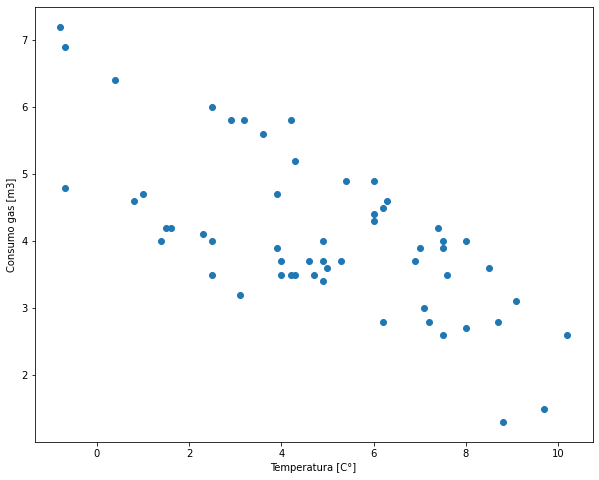

In [235]:
plt.plot(df['Temp'], df['Gas'], 'o')
plt.xlabel('Temperatura [C°]')
_ = plt.ylabel('Consumo gas [m3]')

E' evidente che il consumo di gas è più alto quando fa più freddo.
Ma ora proviamo a considerare anche l'isolamento termico. Possiamo mostrare le osservazioni prima e dopo l'intervento con un colore diverso:

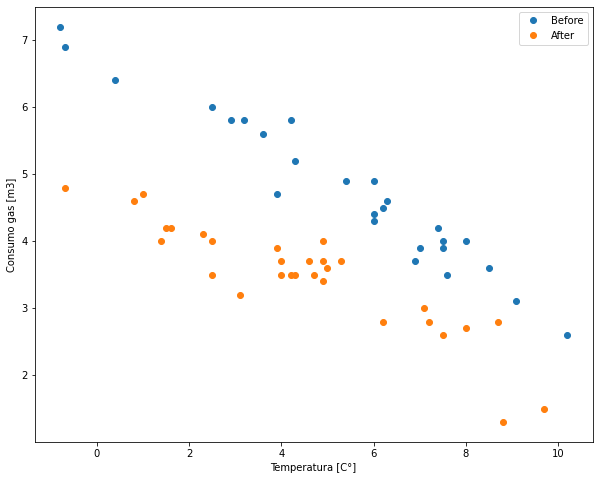

In [236]:
# prima mostriamo i dati prima dell'isolamento
plt.plot(df_before['Temp'], df_before['Gas'], 'o', label='Before')

# ora aggiungiamo mostriamo i dati dopo dell'isolamento
plt.plot(df_after['Temp'], df_after['Gas'], 'o', label='After')

plt.legend()
plt.xlabel('Temperatura [C°]')
_ = plt.ylabel('Consumo gas [m3]')

Da questo grafico si vede come, a parità di temperatura, il consumo di gas è inferiore dopo l'isolamento.
Ora però dobbiamo quantificare quanto si risparmia in termini di gas, data una qualsiasi temperatura!
Per fare ciò abbiamo bisogno di costruire un **modello**, cioè una funzione (o regola) che prendendo in input la temperatura esterna e se la casa ha subito l'intervento o no, restituisce una "predizione" del consumo di gas:

$$gas(temperatura, isolamento)$$

In particolare vogliamo construire un **modello statistico**, perchè il modello imparerà dai dati che gli diamo.

Iniziamo con un modello molto semplice che predice il consumo di gas sapendo la temperatura esterna (per adesso ignoriamo l'isolamento). Il modello più semplice è il modello lineare, cioè:

$$gas(temperatura) = h + m \cdot temperatura$$

Per costruire questo modello, dobbiamo trovare dei valori di $h$ ed $m$ tali per cui, se prendiamo una qualsiasi riga del nostro dataset, cioè una coppia di valori
$(t, g)$, dove $t$ è la temperatura e $g$ è il consumo di gas (per esempio $t=0.8$ e $g=7.2$) allora si verifica che $g \approx gas(t) = h + m \cdot t$, per esempio $7.2 \approx gas(-0.8) = h + m \cdot (-0.8)$. 

Come troviamo questi valori, detti **parametri**, per $h$ ad $m$? Non dobbiamo preoccuparci, per questo esiste una libreria che farà tutto!

In [237]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X=df[['Temp']], y=df['Gas'])

r_squared = model.score(df[['Temp']], df['Gas'])

print(f'Coefficiente (m): {model.coef_[0]:.2f}')
print(f'Intercetta (h): {model.intercept_:.2f}')
print(f'R_squared: {r_squared:.2f}')

Coefficiente (m): -0.29
Intercetta (h): 5.49
R_squared: 0.47


Quindi il modello che abbiamo trovato è

$$ gas(temperatura) = 5.49 -0.29 \cdot temperatura $$

Possiamo vedere la predizione del nostro modello insieme ai dati:

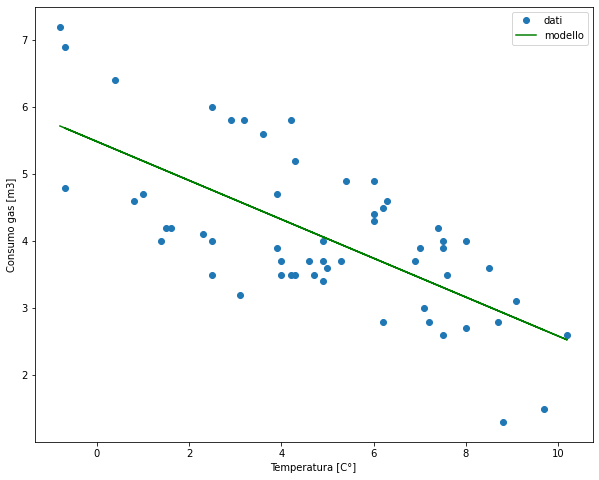

In [238]:
# Come prima, mostriamo tutti dati
plt.plot(df['Temp'], df['Gas'], 'o', label='dati')

# Mostriamo la predizione del modello per ogni punto (unite da una linea continua!)
plt.plot(df['Temp'], model.predict(df[['Temp']]), '-', color='green', label='modello')

plt.xlabel('Temperatura [C°]')
plt.ylabel('Consumo gas [m3]')
_ = plt.legend()

Questo ci mostra semplicemente una relazione tra la temperatura esterna e il consumo di gas. Ma noi siamo interessati al contributo dell'isolamento termico al consumo di gas, quindi dobbiamo aggiungere la variabile "isolamento" al nostro modello: $ gas(temperatura, isolamento) $.

Come possiamo estendere il nostro modello lineare? L'isolamento non è neanche un numero, le colonne sono delle stringhe "Before" e "After". Cosa si fa quando una variabile non è un numero, ma una **categoria**?

La risposta non è univoca, ma in questo caso esiste una possibile soluzione molto semplice: sostituiamo "Before" con 0 e "After" con 1. Adesso il modello lineare può essere costruito, perchè ora "isolamento" è un numero:

$$gas(temperatura, isolamento) = h + m \cdot temperatura + p \cdot isolamento$$

Le variabili che vengono estratte da delle categorie in questo modo vengono chiamate **dummy variables**

In [239]:
# per chiarezza, costruiamo un dataframe solo per questo modello
X = df[['Temp']].copy()

# definiamo la "dummy variable" per l'isolamento
X['Insul_dummy'] = (df['Insul']=='After')*1 # trucco per trasformare False in 0 e True in 1!

# Variable da predire
y = df['Gas']

X

,Temp,Insul_dummy
0,-0.8,0
1,-0.7,0
2,0.4,0
3,2.5,0
4,2.9,0
5,3.2,0
6,3.6,0
7,3.9,0
8,4.2,0
9,4.3,0


In [240]:
# Modello lineare
model = LinearRegression()
model.fit(X, y)

r_squared = model.score(X, y)

print(f'Coefficiente (m): {model.coef_[0]:.2f}')
print(f'Coefficiente (p): {model.coef_[1]:.2f}')
print(f'Intercetta (h): {model.intercept_:.2f}')
print(f'R_squared: {r_squared:.2f}')

Coefficiente (m): -0.34
Coefficiente (p): -1.57
Intercetta (h): 6.55
R_squared: 0.91


Quindi il modello imparato è:
$$ gas(temperatura, isolamento) = 6.55 -0.34 \cdot temperatura - 1.57 \cdot isolamento$$

Un modo equivalente per scrivere questa formula è:

$$
gas(temperatura, isolamento) = 
\begin{cases} 
6.55 -0.34 \cdot temperatura & \text{if } isolamento=Before \\
(6.55-1.57) -0.34 \cdot temperatura& \text{if } isolamento=After
\end{cases}
$$

Questo equivale ad evere un modello lineare la cui intercetta cambia in base alla variabile "isolamento".

Possiamo visualizzare questo modello con due linee distinte:

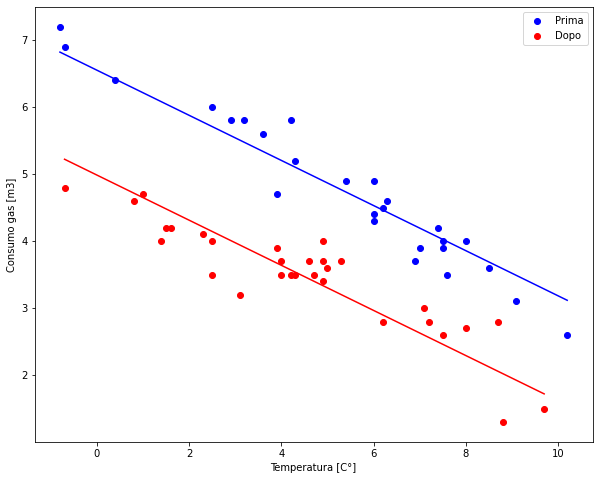

In [243]:
before = X['Insul_dummy']==0
X_before = X[before]
y_before = y[before]
plt.scatter(X_before['Temp'], y_before, color='blue', label = 'Prima')
plt.plot(X_before['Temp'], model.predict(X_before), color='blue')

after = X['Insul_dummy']==1
X_after = X[after]
y_after = y[after]
plt.scatter(X_after['Temp'], y_after, color='red', label = 'Dopo')
plt.plot(X_after['Temp'], model.predict(X_after), color='red')
plt.xlabel('Temperatura [C°]')
plt.ylabel('Consumo gas [m3]')
_ = plt.legend()

Ora possiamo finalmente rispondere alla nostra domanda iniziale: quanto gas viene risparmiato dalla casa grazie all'isolamento termico?
Ora che abbiamo il modello $gas(temperatura, isolamento)$ possiamo stimare il risparmio facendo la differenza tra il consumo stimato senza isolamento e con l'isolamento:

$$ risparmio(temperatura) = gas(temperatura, "Before") - gas(temperatura, "After") = $$

$$ = 6.55 -0.34 \cdot temperatura - ((6.55-1.57) -0.34 \cdot temperatura) = 1.57$$

Coefficiente (m): -0.39
Coefficiente (p): -2.13
Intercetta (h): 6.85
R_squared: 0.93


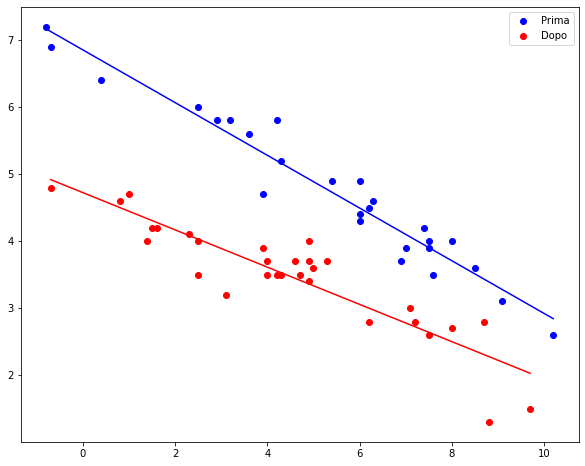

In [244]:
# 'Temp' and 'Insul_encoded' are the independent variables and 'dailyusage' is the dependent variable
df['Insul_dummy'] = (df['Insul']=='After')*1
df['Insul_interaction'] = df['Insul_dummy'] * df['Temp']
X = df[['Temp', 'Insul_dummy', 'Insul_interaction']]
y = df['Gas']

# Create a LinearRegression object
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Print the coefficients of the model
r_squared = model.score(X, y)

print(f'Coefficiente (m): {model.coef_[0]:.2f}')
print(f'Coefficiente (p): {model.coef_[1]:.2f}')
print(f'Intercetta (h): {model.intercept_:.2f}')
print(f'R_squared: {r_squared:.2f}')

before = X['Insul_dummy']==0
X_before = X[before]
y_before = y[before]
plt.scatter(X_before['Temp'], y_before, color='blue', label = 'Prima')
plt.plot(X_before['Temp'], model.predict(X_before), color='blue')

after = X['Insul_dummy']==1
X_after = X[after]
y_after = y[after]
plt.scatter(X_after['Temp'], y_after, color='red', label = 'Dopo')
plt.plot(X_after['Temp'], model.predict(X_after), color='red')
_ = plt.legend()